<h2 align=center> Transfer Learning for NLP with TensorFlow Hub</h2>

---

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker


from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

import pathlib
import shutil
import tempfile

# !pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

Version:  2.4.1
Hub version:  0.11.0
GPU is available


In [2]:
!nvidia-smi

Thu Feb 11 18:05:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##  Download and Import the Quora Insincere Questions Dataset

A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip).

In [4]:
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
                 compression='zip', low_memory=False)
df.shape

(1306122, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


No handles with labels found to put in legend.


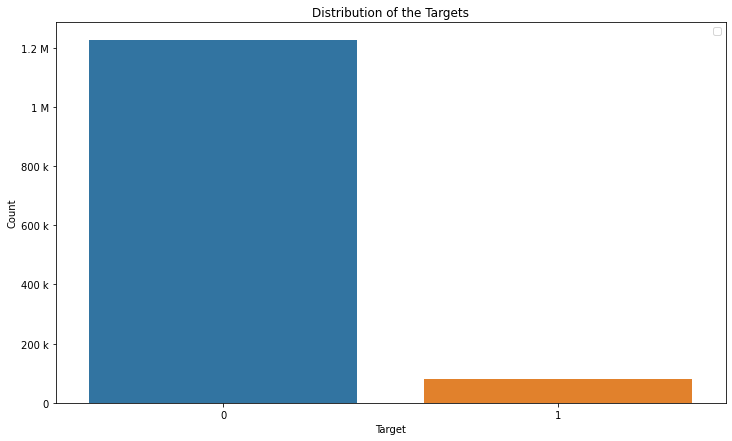

In [10]:
plt.figure(figsize = (12,7))
ax = sns.countplot(data = df, x = 'target')
ax.yaxis.set_major_formatter(ticker.EngFormatter())
plt.title('Distribution of the Targets')
plt.xlabel('Target')
plt.ylabel('Count')
plt.legend()
plt.show()

In [32]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.18, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.01, stratify=remaining.target.values)
train_df.shape, valid_df.shape

((235101, 3), (10710, 3))

In [33]:
train_df['question_text'].sample(10).values

array(['What should I do if my mother hit me for a random thing?',
       'How can I ask questions in a group?',
       'What is the use of plazma 4th state of matter in the recent market?',
       'What will be highest and lowest salaries for robotic and civil engineering if I go through NIT or IIT?',
       'Why do people suffer too much because of financial difficulties?',
       'In which string of guitar does sound travels faster, the thin or the thick one?',
       'Do young people appreciate and respect elders?',
       'My step brother touched me inappropriately when I was 10. It’s been 2 years and I don’t feel safe around him anymore. I haven’t told anyone, what should I do?',
       'Which tech company in San Francisco has the best beer on tap?',
       'What is a redneck pudding?'], dtype=object)

In [34]:
train_df['target'].sample(10).values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

## TensorFlow Hub for NLP

Tensorflow Hub provides a number of [modules](https://tfhub.dev/s?module-type=text-embedding&tf-version=tf2&q=tf2) to convert sentences into embeddings such as Universal sentence ecoders, NNLM, BERT and Wikiwords.

Transfer learning makes it possible to save training resources and to achieve good model generalization even when training on a small dataset.

## Define Function to Build and Compile Models

In [54]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False): # Set true if you want to fine tune the model.
  hub_layer = hub.KerasLayer(module_url, input_shape=[], output_shape=[embed_size], dtype=tf.string, trainable=trainable)
  model = tf.keras.models.Sequential([
                                      hub_layer,
                                      tf.keras.layers.Dense(512, activation='relu'),
                                      tf.keras.layers.Dense(256, activation='relu'),
                                      tf.keras.layers.Dropout(0.21),
                                      tf.keras.layers.Dense(128, activation='relu'),
                                      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
  model.summary()
  history = model.fit(train_df['question_text'], train_df['target'],
                    epochs=8,
                    batch_size=128,
                    validation_data=(valid_df['question_text'], valid_df['target']),
                    callbacks=[tfdocs.modeling.EpochDots(),
                               tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min'),
                               tf.keras.callbacks.TensorBoard(logdir/name)],
                    verbose=1)
  return history

## Train Various Text Classification Models

In [53]:
histories = {}

In [62]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [63]:
histories['universal-sentence-encoder-large'] = train_and_evaluate_model(module_url, embed_size=512, name='universal-sentence-encoder-large')

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_11 (KerasLayer)  (None, 512)               147354880 
_________________________________________________________________
dense_42 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_43 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 129       
Total params: 147,781,889
Trainable params: 427,009
Non-trainable params: 147,354,880
_________________________________

1837/1837 [==============================] - 165s 77ms/step - loss: 0.1436 - accuracy: 0.9473 - val_loss: 0.0996 - val_accuracy: 0.9598

Epoch: 0, accuracy:0.9570,  loss:0.1084,  val_accuracy:0.9598,  val_loss:0.0996,  
.Epoch 2/8
1837/1837 [==============================] - 134s 73ms/step - loss: 0.0903 - accuracy: 0.9633 - val_loss: 0.0990 - val_accuracy: 0.9585
.Epoch 3/8
1837/1837 [==============================] - 135s 74ms/step - loss: 0.0806 - accuracy: 0.9679 - val_loss: 0.1018 - val_accuracy: 0.9587
.Epoch 4/8
1837/1837 [==============================] - 135s 73ms/step - loss: 0.0642 - accuracy: 0.9753 - val_loss: 0.1113 - val_accuracy: 0.9558
.

## Compare Accuracy and Loss Curves

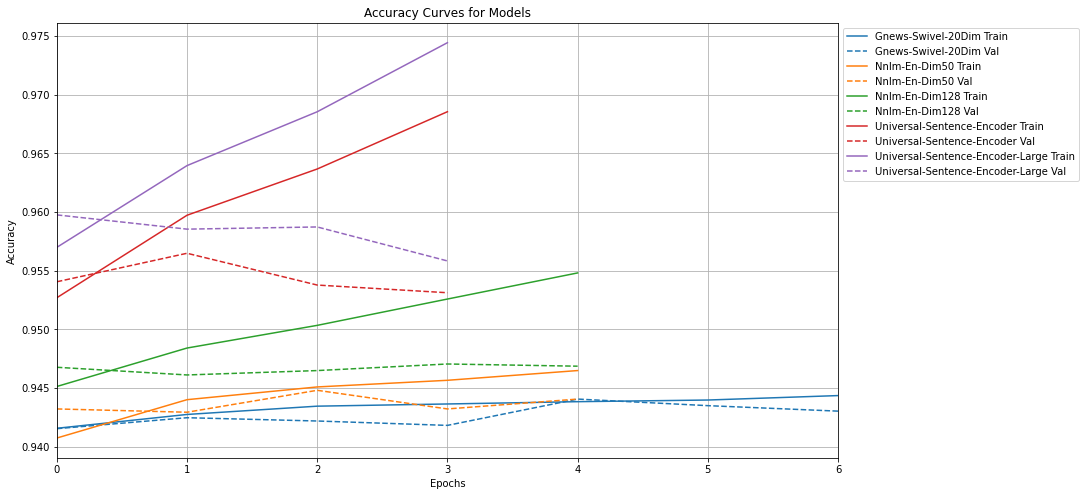

In [64]:
plt.rcParams['figure.figsize'] = (14, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

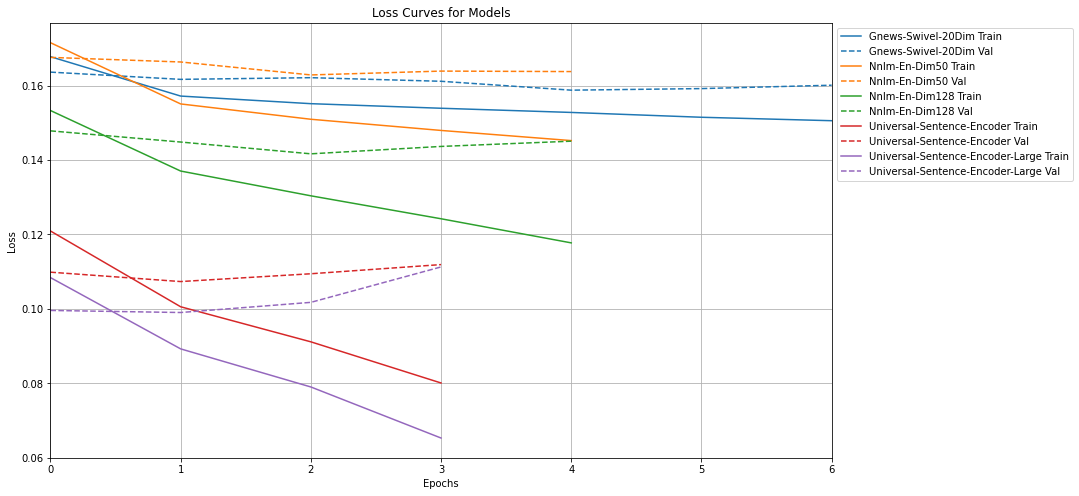

In [65]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()